### NOW EXPERIMENTING:
Pinet:
* custom data generate to update test temperal mask every n epoch
* change unsupervise loss weight on the fly


### Done:
* sample data(train + test) from db, split train data into train val data
* apply test data mask if its none (no temperal mask)
* basic augmentation twice for pinet
* custom pi net loss function


### work: 
* image data augmentation, flip, crop,
* resnet with high dropout, (as resnet so easy overfitting, and not enough data)
* 2d spatial dropout
* dice loss, faster converge, but doesn't help improve score....

### not work:
* deeper, shellower
* Clahe
* pure dice loss, it will give binary solution, rather than probability
* dropout=0.6, overfitting, Val=0.8, LB=0.77

### idea:
* augmentation: rotation, affine transform, Elastic deformations
* reduce dropout, as always under fitting
* smaller batch size
* CRF
* inception block


In [1]:
import numpy as np
import pandas as pd
import time, sys, json, os, io, cv2, base64
from io import BytesIO
from subprocess import check_output
from pprint import pprint as pp
import pymongo
from pymongo import MongoClient
import hashlib
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from random import randint
from skimage import exposure
from tqdm import tqdm_notebook
import gc
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

import keras
from keras.preprocessing.image import load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D, Concatenate, SpatialDropout2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.layers.merge import add
from keras import regularizers
from keras.regularizers import l2
from keras.losses import binary_crossentropy
from keras.activations import softmax
from keras.backend import tensorflow_backend
from keras.backend import common
from keras.callbacks import LambdaCallback
import tensorflow as tf

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
path_train = '../data/train/'
path_test = '../data/test/'
train_ids = next(os.walk(path_train))[2]
test_ids = next(os.walk(path_test))[2]
depths_df = pd.read_csv("../data/depths.csv", index_col="id")
train_df = pd.read_csv("../data/train.csv", index_col="id")

In [3]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """
    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)
    return conn[db]

def insert_data(data, db, collection, check_id='id', host='localhost', port=27017, username=None, password=None, no_id=True):
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    
    duplicate_result = db[collection].find(
       {check_id: data[check_id]})
    
    print('duplicate count' + str(duplicate_result.count()))
    if duplicate_result.count() == 0:
        db[collection].insert_one(data)

def set_data(db, collection, search, set_query, host='localhost', port=27017, username=None, password=None, no_id=True):
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    db[collection].update(
        search,
        { '$set': set_query }
    )
        
def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

def sample_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True, num_sample=1000):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].aggregate([{ "$sample": { "size": num_sample }}])

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

# Put all dataset into DF frist, hold in memory

In [4]:
img_size_ori = 101
img_size_target = 128

def read_resize_img(x, scale,mask=False):
    img_byte = io.BytesIO(base64.b64decode(x))
    img_np = np.array(imread(img_byte, as_gray=True))/scale
    img_np = resize(img_np,(img_size_target,img_size_target), mode='constant', preserve_range=True)
    if mask:
        img_np[img_np>0] = 1
    return img_np

train_df = read_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$ne":None}}]})
test_df = read_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$eq":None}}]})
# test_df = sample_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$eq":None}}]})

# train_df = train_df.loc[:20]

train_df['img'] = train_df['img_base64'].apply(lambda x: read_resize_img(x, 256.0))
train_df['img_mask'] = train_df['img_mask_base64'].apply(lambda x: read_resize_img(x, 65535.0, mask=True))
train_df['img_temperal_mask'] = train_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))
test_df['img'] = test_df['img_base64'].apply(lambda x: read_resize_img(x, 256.0))
test_df['img_mask'] = test_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))
test_df['img_temperal_mask'] = test_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))

train_df = train_df.drop('img_base64', axis=1)
train_df = train_df.drop('img_mask_base64', axis=1)
train_df = train_df.drop('ASM', axis=1)
train_df = train_df.drop('contrast', axis=1)
train_df = train_df.drop('correlation', axis=1)
train_df = train_df.drop('dissimilarity', axis=1)
train_df = train_df.drop('energy', axis=1)
train_df = train_df.drop('entropy', axis=1)
train_df = train_df.drop('homogeneity', axis=1)
train_df = train_df.drop('coverage', axis=1)
train_df = train_df.drop('coverage_class', axis=1)
test_df = test_df.drop('img_base64', axis=1)

train_df, val_df = train_test_split(train_df, test_size=0.1)

In [5]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3600, 7)
(400, 7)
(18000, 6)


# Data Preprcessing function: sample, augment, to np_array

In [6]:
def _img_augmentation(_df):
    def random_crop_resize(x, crop, flip):
        x = np.fliplr(x) if flip else x
        x = x[crop[0]:-crop[1],crop[2]:-crop[3]]
        x = resize(x,(img_size_target,img_size_target), mode='constant', preserve_range=True)
        return x

    def img_augment(df):
        augment_df = pd.DataFrame()
        for index, row in df.iterrows():
            # np.random.seed(0)
            crop = np.random.randint(low=1, high=10, size=4)
            flip = np.random.choice([True, False])
            aug_img = random_crop_resize(row['img'], crop, flip)
            aug_img_mask = random_crop_resize(row['img_mask'], crop, flip)
            aug_img_temperal_mask = random_crop_resize(row['img_temperal_mask'], crop, flip)

            augment_df = augment_df.append(
                {
                    'depth': row['depth'],
                    'img_id': row['img_id']+'_augment',
                    'aug_img': aug_img,
                    'aug_img_mask': aug_img_mask,
                    'aug_img_temperal_mask': aug_img_temperal_mask,
                }, ignore_index=True
            )
        return augment_df
    
    _augment_df = img_augment(_df)
    
    return _augment_df

def _convert_to_np_array(_augment_df):
    X_np = np.expand_dims(np.stack((np.asarray(_augment_df['aug_img'].values.tolist()))),axis=3)
    y_np = np.expand_dims(np.asarray(_augment_df['aug_img_mask'].values.tolist()),axis=3)
    y_temp_np = np.expand_dims(np.asarray(_augment_df['aug_img_temperal_mask'].values.tolist()),axis=3)
    y_np = np.concatenate((y_np,y_temp_np),axis=3)
    
    return X_np, y_np

def calculate_test_temperal_mask():
    global model_train, test_df, graph_train
    with graph_train.as_default():
        X_test = np.expand_dims(np.stack((np.asarray(test_df['img'].values.tolist()))),axis=3)
        predict_test = model_train.predict(X_test,batch_size=16, verbose=1)
        predict_test = np.squeeze(predict_test)
    
    for index, row in tqdm_notebook(test_df.iterrows(),total=len(test_df.index)):
        img_temperal_mask = row['img_temperal_mask']
        predict = predict_test[index]
        if(np.mean(img_temperal_mask) == -1):
            test_df.at[index,'img_temperal_mask'] = predict
        else:
            test_df.at[index,'img_temperal_mask'] = (img_temperal_mask + predict)/2
    return test_df

# plot some data

In [7]:
# %%time
# sample_train_df, sample_val_df, sample_test_df = sample_df(train_df, val_df, test_df)
# train_augment_df, val_augment_df, test_augment_df = img_augmentation(sample_train_df, sample_val_df, sample_test_df)
# X_train, y_train, X_valid, y_valid = convert_to_np_array(train_augment_df, val_augment_df, test_augment_df)

# test_augment_df.head(1)

In [8]:
# base_idx = 0
# max_images = 16
# grid_width = 4
# grid_height = int(max_images / grid_width)
# fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
# row = 0; col = 0;
# for i, idx in enumerate(train_augment_df.index[base_idx:base_idx+int(max_images)]):
#     img = train_augment_df.loc[idx].aug_img
#     mask = train_augment_df.loc[idx].aug_img_mask
    
#     ax = axs[row, col];
#     ax.imshow(img, cmap="seismic")
# #     ax.imshow(img, cmap="gray")
#     ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
#     ax.set_yticklabels([]); ax.set_xticklabels([]);
    
#     if col >= grid_width:
#         col=0; row+=1;


# Custom loss function

In [9]:
from debug import _debug_func

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

def keras_binary_crossentropy(target, output, from_logits=False):
        # Note: tf.nn.sigmoid_cross_entropy_with_logits
        # expects logits, Keras expects probabilities.
        if not from_logits:
            # transform back to logits
            _epsilon = tensorflow_backend._to_tensor(common.epsilon(), output.dtype.base_dtype)
            output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
            output = tf.log(output / (1 - output))
        
        # this will return a tensor
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target,
                                                       logits=output)

# MSE between current and temporal outputs
def temperal_mse_loss(y_true, y_pred):
    y_temperal = tf.slice(y_true, [0, 0, 0, 1], [-1, -1, -1, 1])
#         y_temperal = _debug_func(y_temperal,"y_temperal")

    # count temperal size which has value (not -1)
    temperal_size=tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_min(y_temperal, [1,2,3]), -1), tf.float32))

    # generate filter using y_temperal
    temperal_filter = tf.cast(tf.not_equal(y_temperal, -1), tf.float32)

    # filter out MSE if temperal = -1
    quad_diff = K.sum(temperal_filter*((y_pred - y_temperal) ** 2))

    quad_diff = quad_diff / (temperal_size*128*128+1e-15)

    return quad_diff

def masked_crossentropy(y_true, y_pred):
    y_mask = tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1])

    # count mask size
    mask_size=tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_min(y_mask, [1,2,3]), -1), tf.float32))

    # generate mask filter as test doesn't have mask (-1)
    mask_filter = tf.cast(tf.not_equal(y_mask, -1), tf.float32)

    bce_loss = keras_binary_crossentropy(y_mask, y_pred)

    dice_loss_ = dice_loss(mask_filter*y_mask, mask_filter*y_pred)

    bce_dice_loss = dice_loss_ + (K.sum(mask_filter*bce_loss) / (mask_size*128*128+1e-15))

    return bce_dice_loss

def mask_mean_iou(y_true, y_pred):
    y_mask = tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1])
    mask_filter = tf.cast(tf.not_equal(y_mask, -1), tf.float32)
    mask_mean_iou = mean_iou(mask_filter*y_mask, mask_filter*y_pred)
    return mask_mean_iou

def temperal_mean_iou(y_true, y_pred):
    y_temperal = tf.slice(y_true, [0, 0, 0, 1], [-1, -1, -1, 1])
    temperal_filter = tf.cast(tf.not_equal(y_temperal, -1), tf.float32)
    temperal_mean_iou = mean_iou(temperal_filter*y_temperal, temperal_filter*y_pred)
    return temperal_mean_iou

def temporal_loss(y_true, y_pred):
    sup_loss = masked_crossentropy(y_true, y_pred)
    unsup_loss = temperal_mse_loss(y_true, y_pred)
    w = 0.01
    
    return sup_loss + w * unsup_loss

# DataGenerator

In [10]:
class DataGenerator(keras.utils.Sequence):
    #class static variable
    global model_train
    _train_df = None
    _val_df = None
    _test_df = None
    _X_train = None
    _y_train = None
    _X_valid = None
    _y_valid = None
    
    'Generates data for Keras'
    def __init__(self, train_df, val_df, test_df, batch_size=32, shuffle=True, training=True, temperal_epoch=5):
        self.training = training
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.epoch = 0
        self.train_size = train_df.shape[0]
        self.val_size = val_df.shape[0]
        self.test_size = test_df.shape[0]
        self.train_batch_size = int(self.train_size / (self.train_size + self.test_size)*self.batch_size)
        self.val_batch_size = self.batch_size
        self.test_batch_size = self.batch_size - self.train_batch_size
        self.temperal_epoch = temperal_epoch
        
        print(f'train_size = {self.train_size}, \
              val_size = {self.val_size}, \
              test_size = {self.test_size}, \
              train_batch_size = {self.train_batch_size}, \
              val_batch_size = {self.val_batch_size}, \
              test_batch_size = {self.test_batch_size}, \
              ')
        
        'Initial static variable'
        if self.training:
            DataGenerator._train_df = train_df
            DataGenerator._val_df = val_df
            DataGenerator._test_df = test_df

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.training:
            print('train lenght')
            print(int(np.floor((self.train_size + self.test_size) / self.batch_size)))
            return int(np.floor((self.train_size + self.test_size) / self.batch_size))
        else:
            print('val lenght')
            print(int(np.floor(self.val_size / self.batch_size)))
            return int(np.floor(self.val_size / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        'index: indicate which batch in a epoch, (first, second or third batch)'
        # Generate indexes of the batch
        if self.training:
            if ((index+1)*self.train_batch_size > self.train_size) or ((index+1)*self.test_batch_size > self.test_size):
                index = 0    
            
            # slice batch of df
            batch_train_df = DataGenerator._train_df.iloc[index*self.train_batch_size:(index+1)*self.train_batch_size]
            batch_test_df = DataGenerator._test_df.iloc[index*self.test_batch_size:(index+1)*self.test_batch_size]
            
            # image augmentation
            train_augment_df = _img_augmentation(batch_train_df)
            test_augment_df = _img_augmentation(batch_test_df)
            
            # convert to np and concat train and test
            X_train_np, y_train_np = _convert_to_np_array(train_augment_df)
            X_test_np, y_test_np = _convert_to_np_array(test_augment_df)
            X_train_np = np.concatenate((X_train_np,X_test_np),axis=0)
            y_train_np = np.concatenate((y_train_np,y_test_np),axis=0)
            
            return X_train_np, y_train_np
        else:
            batch_val_df = DataGenerator._val_df.iloc[index*self.val_batch_size:(index+1)*self.val_batch_size]
            val_augment_df = _img_augmentation(batch_val_df)
            X_val_np, y_val_np = _convert_to_np_array(val_augment_df)
            return X_val_np, y_val_np

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        print(f', epoch={self.epoch}')
        self.epoch += 1
        if self.epoch % self.temperal_epoch == 0 and self.training:
            new_test_df = calculate_test_temperal_mask()
            DataGenerator._test_df = new_test_df

# Build Unet + Resnet

In [11]:
# tensorflow session setting
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
set_session(tf.Session(config=tf_config))

def conv_block(m, dim, acti, bn, res, do=0, training=None):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = SpatialDropout2D(do/2.0)(n, training=training) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    n = Concatenate()([m, n]) if res else n
    n = SpatialDropout2D(do)(n, training=training) if do else n
    return n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res,training=None):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res, training=training)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res, training=training)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res, training=training)
    else:
        m = conv_block(m, dim, acti, bn, res, do, training=training)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=5, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=True, training=None):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual, training=training)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

# model.compile(loss='binary_crossentropy', optimizer="adam", metrics=[mean_iou,"accuracy"])
# model_train.compile(loss=bce_dice_loss, optimizer="adam", metrics=[mean_iou,"accuracy"])

# used for training unsuperivsed, that keep dropout
global model_train, graph_train
model_train = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True, dropout=0.6, training=True)
model_train.compile(loss=temporal_loss, optimizer="adam", metrics=[masked_crossentropy, temperal_mse_loss, mask_mean_iou, temperal_mean_iou])
model_train.summary()
graph_train = tf.get_default_graph()

# # used for predict, no dropout
# model_predict = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True, dropout=0.6, training=False)
# model_predict.compile(loss=temporal_loss, optimizer="adam", metrics=[masked_crossentropy, temperal_mse_loss, mask_mean_iou, temperal_mean_iou])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [19]:
epochs = 100
batch_size = 32
callbacks = [
    EarlyStopping(patience=10, verbose=1, monitor="val_mask_mean_iou", mode="max"),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-unet-resnet.h5', verbose=1, save_best_only=True, monitor="val_mask_mean_iou", mode="max"),
]

training_generator = DataGenerator(train_df, val_df, test_df, training=True)
validation_generator = DataGenerator(train_df, val_df, test_df, training=False)

history = model_train.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=epochs, callbacks=callbacks,
                    use_multiprocessing=True,
                    workers=10)

train_size = 3600,               val_size = 400,               test_size = 18000,               train_batch_size = 5,               val_batch_size = 32,               test_batch_size = 27,               
train_size = 3600,               val_size = 400,               test_size = 18000,               train_batch_size = 5,               val_batch_size = 32,               test_batch_size = 27,               
val lenght
12
train lenght
675
train lenght
675
Epoch 1/50
674/675 [============================>.] - ETA: 0s - loss: 0.1280 - masked_crossentropy: 0.1278 - temperal_mse_loss: 0.0195 - mask_mean_iou: 0.8888 - temperal_mean_iou: 0.4146, epoch=0
val lenght
12
val lenght
12
, epoch=0
675/675 [==============================] - 311s 461ms/step - loss: 0.1285 - masked_crossentropy: 0.1283 - temperal_mse_loss: 0.0195 - mask_mean_iou: 0.8888 - temperal_mean_iou: 0.4146 - val_loss: 0.3498 - val_masked_crossentropy: 0.3498 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8893 - val_tem

18000/18000 [==============================] - 207s 12ms/step




675/675 [==============================] - 526s 779ms/step - loss: 0.1222 - masked_crossentropy: 0.1220 - temperal_mse_loss: 0.0197 - mask_mean_iou: 0.8925 - temperal_mean_iou: 0.4138 - val_loss: 0.3699 - val_masked_crossentropy: 0.3699 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8930 - val_temperal_mean_iou: 0.4137

Epoch 00005: val_mask_mean_iou improved from 0.89208 to 0.89298, saving model to model-unet-resnet.h5
Epoch 6/50
674/675 [============================>.] - ETA: 0s - loss: 0.1274 - masked_crossentropy: 0.1272 - temperal_mse_loss: 0.0206 - mask_mean_iou: 0.8934 - temperal_mean_iou: 0.4136, epoch=5
val lenght
12
val lenght
12
, epoch=5
675/675 [==============================] - 310s 460ms/step - loss: 0.1273 - masked_crossentropy: 0.1271 - temperal_mse_loss: 0.0206 - mask_mean_iou: 0.8934 - temperal_mean_iou: 0.4136 - val_loss: 0.3634 - val_masked_crossentropy: 0.3634 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8938 - val_temperal_mean_iou: 0.

18000/18000 [==============================] - 206s 11ms/step



675/675 [==============================] - 521s 772ms/step - loss: 0.1224 - masked_crossentropy: 0.1222 - temperal_mse_loss: 0.0204 - mask_mean_iou: 0.8966 - temperal_mean_iou: 0.4132 - val_loss: 0.3764 - val_masked_crossentropy: 0.3764 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8970 - val_temperal_mean_iou: 0.4132

Epoch 00010: val_mask_mean_iou improved from 0.89622 to 0.89697, saving model to model-unet-resnet.h5
Epoch 11/50
674/675 [============================>.] - ETA: 0s - loss: 0.1260 - masked_crossentropy: 0.1258 - temperal_mse_loss: 0.0203 - mask_mean_iou: 0.8973 - temperal_mean_iou: 0.4132, epoch=10
val lenght
12
val lenght
12
, epoch=10
675/675 [==============================] - 311s 461ms/step - loss: 0.1259 - masked_crossentropy: 0.1257 - temperal_mse_loss: 0.0203 - mask_mean_iou: 0.8973 - temperal_mean_iou: 0.4132 - val_loss: 0.3695 - val_masked_crossentropy: 0.3695 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8977 - val_temperal_mean_iou: 

18000/18000 [==============================] - 206s 11ms/step



675/675 [==============================] - 520s 771ms/step - loss: 0.1216 - masked_crossentropy: 0.1214 - temperal_mse_loss: 0.0196 - mask_mean_iou: 0.9000 - temperal_mean_iou: 0.4131 - val_loss: 0.3648 - val_masked_crossentropy: 0.3648 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.9004 - val_temperal_mean_iou: 0.4130

Epoch 00015: val_mask_mean_iou improved from 0.89973 to 0.90038, saving model to model-unet-resnet.h5
Epoch 16/50
674/675 [============================>.] - ETA: 0s - loss: 0.1183 - masked_crossentropy: 0.1181 - temperal_mse_loss: 0.0204 - mask_mean_iou: 0.9007 - temperal_mean_iou: 0.4130, epoch=15
val lenght
12
val lenght
12
, epoch=15
675/675 [==============================] - 314s 466ms/step - loss: 0.1184 - masked_crossentropy: 0.1182 - temperal_mse_loss: 0.0204 - mask_mean_iou: 0.9007 - temperal_mean_iou: 0.4130 - val_loss: 0.3604 - val_masked_crossentropy: 0.3604 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.9010 - val_temperal_mean_iou: 

18000/18000 [==============================] - 205s 11ms/step



675/675 [==============================] - 520s 770ms/step - loss: 0.1213 - masked_crossentropy: 0.1211 - temperal_mse_loss: 0.0199 - mask_mean_iou: 0.9031 - temperal_mean_iou: 0.4132 - val_loss: 0.3849 - val_masked_crossentropy: 0.3849 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.9034 - val_temperal_mean_iou: 0.4132

Epoch 00020: val_mask_mean_iou improved from 0.90281 to 0.90337, saving model to model-unet-resnet.h5
Epoch 21/50
674/675 [============================>.] - ETA: 0s - loss: 0.1238 - masked_crossentropy: 0.1236 - temperal_mse_loss: 0.0207 - mask_mean_iou: 0.9036 - temperal_mean_iou: 0.4132, epoch=20
val lenght
12
val lenght
12
, epoch=20
675/675 [==============================] - 309s 458ms/step - loss: 0.1238 - masked_crossentropy: 0.1236 - temperal_mse_loss: 0.0207 - mask_mean_iou: 0.9036 - temperal_mean_iou: 0.4132 - val_loss: 0.3623 - val_masked_crossentropy: 0.3623 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.9039 - val_temperal_mean_iou: 

18000/18000 [==============================] - 205s 11ms/step



675/675 [==============================] - 519s 769ms/step - loss: 0.1206 - masked_crossentropy: 0.1204 - temperal_mse_loss: 0.0210 - mask_mean_iou: 0.9057 - temperal_mean_iou: 0.4134 - val_loss: 0.3897 - val_masked_crossentropy: 0.3897 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.9059 - val_temperal_mean_iou: 0.4135

Epoch 00025: val_mask_mean_iou improved from 0.90544 to 0.90593, saving model to model-unet-resnet.h5
Epoch 26/50
674/675 [============================>.] - ETA: 0s - loss: 0.1208 - masked_crossentropy: 0.1206 - temperal_mse_loss: 0.0206 - mask_mean_iou: 0.9062 - temperal_mean_iou: 0.4135, epoch=25
val lenght
12
val lenght
12
, epoch=25
675/675 [==============================] - 309s 458ms/step - loss: 0.1207 - masked_crossentropy: 0.1205 - temperal_mse_loss: 0.0206 - mask_mean_iou: 0.9062 - temperal_mean_iou: 0.4135 - val_loss: 0.4036 - val_masked_crossentropy: 0.4036 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.9064 - val_temperal_mean_iou: 

18000/18000 [==============================] - 206s 11ms/step



675/675 [==============================] - 520s 770ms/step - loss: 0.1145 - masked_crossentropy: 0.1143 - temperal_mse_loss: 0.0219 - mask_mean_iou: 0.9079 - temperal_mean_iou: 0.4143 - val_loss: 0.3833 - val_masked_crossentropy: 0.3833 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.9082 - val_temperal_mean_iou: 0.4144

Epoch 00030: val_mask_mean_iou improved from 0.90773 to 0.90817, saving model to model-unet-resnet.h5
Epoch 31/50
674/675 [============================>.] - ETA: 0s - loss: 0.1194 - masked_crossentropy: 0.1192 - temperal_mse_loss: 0.0210 - mask_mean_iou: 0.9084 - temperal_mean_iou: 0.4145, epoch=30
val lenght
12
val lenght
12
, epoch=30
675/675 [==============================] - 310s 459ms/step - loss: 0.1195 - masked_crossentropy: 0.1193 - temperal_mse_loss: 0.0210 - mask_mean_iou: 0.9084 - temperal_mean_iou: 0.4145 - val_loss: 0.3596 - val_masked_crossentropy: 0.3596 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.9086 - val_temperal_mean_iou: 

18000/18000 [==============================] - 205s 11ms/step



675/675 [==============================] - 520s 770ms/step - loss: 0.1135 - masked_crossentropy: 0.1133 - temperal_mse_loss: 0.0211 - mask_mean_iou: 0.9100 - temperal_mean_iou: 0.4154 - val_loss: 0.3799 - val_masked_crossentropy: 0.3799 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.9102 - val_temperal_mean_iou: 0.4155

Epoch 00035: val_mask_mean_iou improved from 0.90980 to 0.91019, saving model to model-unet-resnet.h5
Epoch 36/50
674/675 [============================>.] - ETA: 0s - loss: 0.1162 - masked_crossentropy: 0.1160 - temperal_mse_loss: 0.0212 - mask_mean_iou: 0.9104 - temperal_mean_iou: 0.4156, epoch=35
val lenght
12
val lenght
12
, epoch=35
675/675 [==============================] - 310s 460ms/step - loss: 0.1161 - masked_crossentropy: 0.1159 - temperal_mse_loss: 0.0213 - mask_mean_iou: 0.9104 - temperal_mean_iou: 0.4156 - val_loss: 0.4205 - val_masked_crossentropy: 0.4205 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.9106 - val_temperal_mean_iou: 

18000/18000 [==============================] - 205s 11ms/step



675/675 [==============================] - 522s 773ms/step - loss: 0.1154 - masked_crossentropy: 0.1152 - temperal_mse_loss: 0.0210 - mask_mean_iou: 0.9118 - temperal_mean_iou: 0.4164 - val_loss: 0.4084 - val_masked_crossentropy: 0.4084 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.9120 - val_temperal_mean_iou: 0.4165

Epoch 00040: val_mask_mean_iou improved from 0.91164 to 0.91199, saving model to model-unet-resnet.h5
Epoch 41/50
674/675 [============================>.] - ETA: 0s - loss: 0.1152 - masked_crossentropy: 0.1150 - temperal_mse_loss: 0.0207 - mask_mean_iou: 0.9122 - temperal_mean_iou: 0.4166, epoch=40
val lenght
12
val lenght
12
, epoch=40
675/675 [==============================] - 310s 459ms/step - loss: 0.1151 - masked_crossentropy: 0.1149 - temperal_mse_loss: 0.0207 - mask_mean_iou: 0.9122 - temperal_mean_iou: 0.4166 - val_loss: 0.3761 - val_masked_crossentropy: 0.3761 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.9123 - val_temperal_mean_iou: 

18000/18000 [==============================] - 206s 11ms/step



675/675 [==============================] - 520s 770ms/step - loss: 0.1116 - masked_crossentropy: 0.1114 - temperal_mse_loss: 0.0213 - mask_mean_iou: 0.9135 - temperal_mean_iou: 0.4174 - val_loss: 0.3731 - val_masked_crossentropy: 0.3731 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.9137 - val_temperal_mean_iou: 0.4175

Epoch 00045: val_mask_mean_iou improved from 0.91335 to 0.91366, saving model to model-unet-resnet.h5
Epoch 46/50
674/675 [============================>.] - ETA: 0s - loss: 0.1143 - masked_crossentropy: 0.1140 - temperal_mse_loss: 0.0213 - mask_mean_iou: 0.9138 - temperal_mean_iou: 0.4176, epoch=45
val lenght
12
val lenght
12
, epoch=45
675/675 [==============================] - 310s 459ms/step - loss: 0.1142 - masked_crossentropy: 0.1140 - temperal_mse_loss: 0.0213 - mask_mean_iou: 0.9138 - temperal_mean_iou: 0.4176 - val_loss: 0.3694 - val_masked_crossentropy: 0.3694 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.9140 - val_temperal_mean_iou: 

18000/18000 [==============================] - 205s 11ms/step



675/675 [==============================] - 520s 771ms/step - loss: 0.1103 - masked_crossentropy: 0.1101 - temperal_mse_loss: 0.0215 - mask_mean_iou: 0.9150 - temperal_mean_iou: 0.4184 - val_loss: 0.4185 - val_masked_crossentropy: 0.4185 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.9152 - val_temperal_mean_iou: 0.4185

Epoch 00050: val_mask_mean_iou improved from 0.91487 to 0.91517, saving model to model-unet-resnet.h5


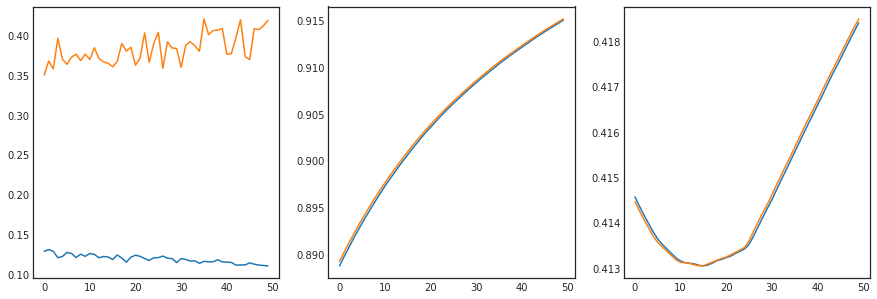

In [20]:
fig, (ax_loss, ax_acc, ax_iou) = plt.subplots(1, 3, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["mask_mean_iou"], label="Train mask iou")
ax_acc.plot(history.epoch, history.history["val_mask_mean_iou"], label="Validation mask iou")
ax_iou.plot(history.epoch, history.history["temperal_mean_iou"], label="Train temperal iou")
ax_iou.plot(history.epoch, history.history["val_temperal_mean_iou"], label="Validation temperal iou")

In [21]:
# model = load_model("./model-unet-resnet.h5", custom_objects={'mean_iou':mean_iou})

X_valid = np.expand_dims(np.stack((np.asarray(val_df['img'].values.tolist()))),axis=3)
y_valid = np.expand_dims(np.asarray(val_df['img_mask'].values.tolist()),axis=3)
preds_valid = model_train.predict(X_valid, batch_size=32, verbose=1)

400/400 [==============================] - 2s 5ms/step


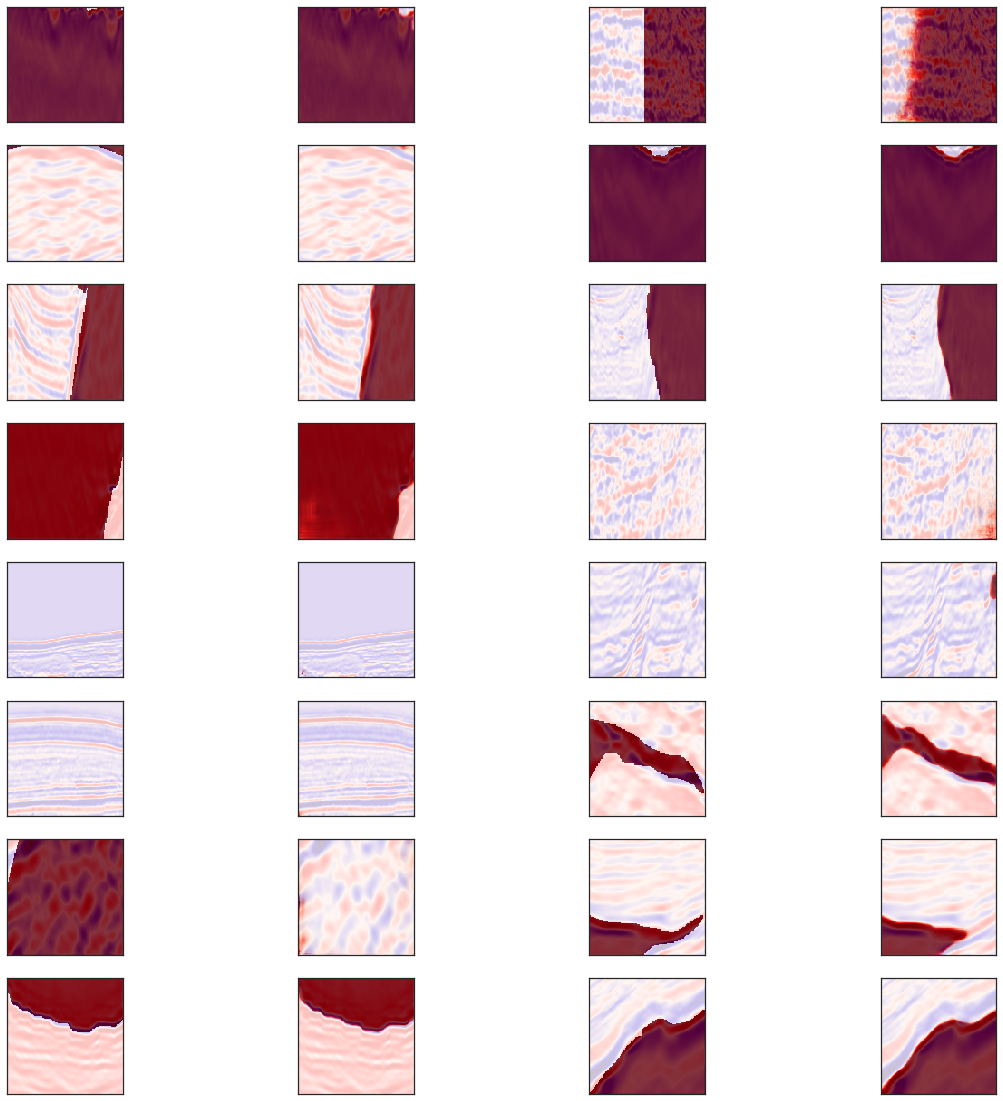

In [22]:
# plot some validate result
base_idx = 10
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i, idx in enumerate(val_df.index[base_idx:base_idx+int(max_images/2)]):
    img = val_df.iloc[i].img
    mask = val_df.iloc[i].img_mask
    pred = preds_valid[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(pred, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]);ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


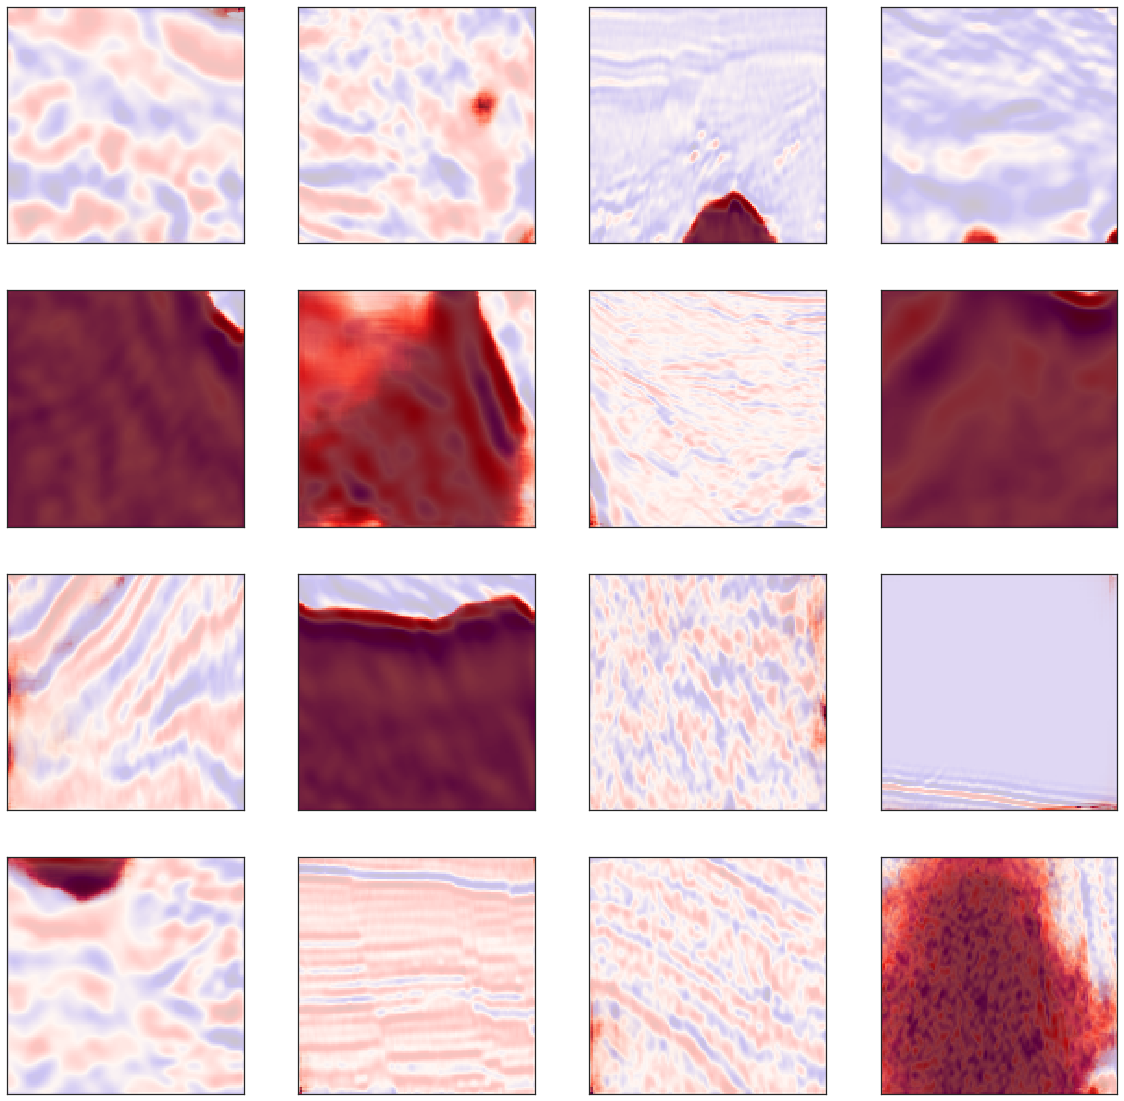

In [23]:
# plot some temperal mask on test results
base_idx = 0
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i, idx in enumerate(test_df.index[base_idx:base_idx+int(max_images)]):
    img = test_df.loc[idx].img
    mask = test_df.loc[idx].img_temperal_mask
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
#     ax.imshow(img, cmap="gray")
    ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


In [24]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch],print_table=False)
        metric.append(value)
    return np.mean(metric)


from math import sqrt
from joblib import Parallel, delayed
import multiprocessing  
from tqdm import tqdm  

thresholds = np.linspace(0, 1, 20)
# result = Parallel(n_jobs=2)(io_metric_batch(train_y, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds))
# ious = np.array([iou_metric_batch(train_y, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])
ious = np.array([iou_metric_batch(y_valid, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

threshold_best: 0.47368421052631576, iou_best: 0.8045


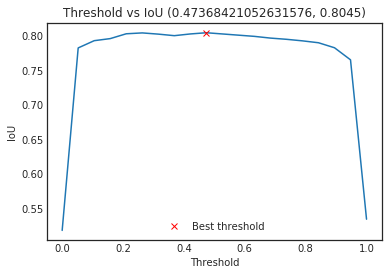

In [25]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

print(f'threshold_best: {threshold_best}, iou_best: {iou_best}')

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()